In [1]:
%load_ext autoreload
%autoreload 2

Extracting files to /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Original..
Finished extracting files to /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Original


Processing subjects..: 100%|██████████| 7/7 [00:00<00:00, 36.78it/s]


Saving compressed 3d positions into /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Original/data_3d_h36m
Finished saving 3d positions into /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Original/data_3d_h36m
Computing ground-truth 2D poses...
Saving compressed 2d positions into /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Original/data_2d_h36m_gt
Done saving compressed 2d positions into /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Original/data_2d_h36m_gt
Reading 3d npz file
Reading 2d npz file
Done
Creating train datasets and saving into file
Saved pose actions in file /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Processed/train_actions.npy
Saved 3d poses in file /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Processed/train_3d_poses.npy
Saved 2d poses in file /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Processed/train_2d_poses.npy
Creating test datasets and saving into file
Saved pose actions in file /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Processed/test_actions.npy
Saved 3d poses in file /U

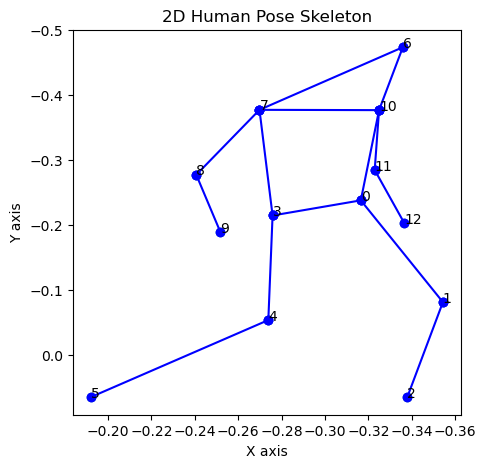

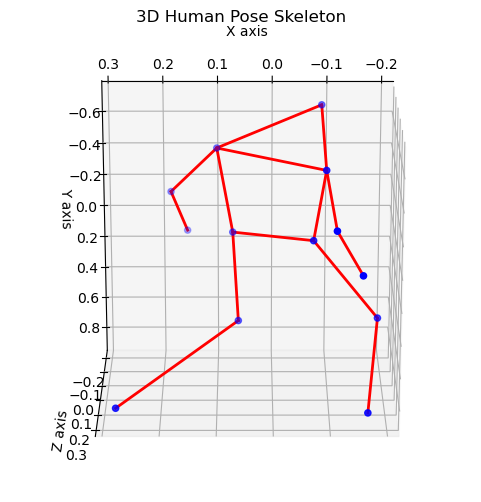

In [2]:
import os 
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np

from data.camera import world_to_camera, project_to_2d, image_coordinates, wrap
from data.h36m_dataset import Human36mDataset
from utils.data_utils import read_3d_data, create_2d_data, create_train_test_files
from data.h36m_dataset import TRAIN_SUBJECTS, TEST_SUBJECTS, Human36mDataset
from utils.visualization_utils import visualize_2d_pose, visualize_3d_pose


folder_path = os.path.join(os.getcwd(),"datasets", "h36m", "Original")
zip_file_path = os.path.join(folder_path, 'h36m.zip')


# extracting the contents inside the /datasets/h36m/Original folder
import zipfile

print(f"Extracting files to {folder_path}..")
# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f"Finished extracting files to {folder_path}")


output_filename = os.path.join(folder_path, 'data_3d_h36m')
subjects = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']

output = dict()
for subject in tqdm(subjects, desc= f'Processing subjects..'):
    output[subject] = dict()
    file_list = glob(os.path.join(folder_path, 'h36m', subject, 'MyPoses', '3D_positions', '*.h5'))
    assert len(file_list) == 30, "Expected 30 files for subject " + subject + ", got " + str(len(file_list))
    for f in file_list:
        action = os.path.splitext(os.path.basename(f))[0]

        if subject == 'S11' and action == 'Directions':
            continue  # Discard corrupted video

        with h5py.File(f) as hf:
            positions = hf.get('3D_positions')[:].reshape(32, 3, -1).transpose(2, 0, 1)
            positions /= 1000  # Meters instead of millimeters
            output[subject][action] = positions.astype('float32')

print(f'Saving compressed 3d positions into {output_filename}')
np.savez_compressed(output_filename, positions_3d=output)
print(f'Finished saving 3d positions into {output_filename}')
del output

print('Computing ground-truth 2D poses...')
output_filename_2d = os.path.join(folder_path, 'data_2d_h36m_gt')

dataset = Human36mDataset(output_filename + '.npz')
output_2d_poses = {}
for subject in dataset.subjects():
    output_2d_poses[subject] = {}
    for action in dataset[subject].keys():
        anim = dataset[subject][action]

        positions_2d = []
        for cam in anim['cameras']:
            pos_3d = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])
            pos_2d = wrap(project_to_2d, True, pos_3d, cam['intrinsic'])
            pos_2d_pixel_space = image_coordinates(pos_2d, w=cam['res_w'], h=cam['res_h'])
            positions_2d.append(pos_2d_pixel_space.astype('float32'))
        output_2d_poses[subject][action] = positions_2d

print(f'Saving compressed 2d positions into {output_filename_2d}')
metadata = {
    'num_joints': dataset.skeleton().num_joints(),
    'keypoints_symmetry': [dataset.skeleton().joints_left(), dataset.skeleton().joints_right()]
}
np.savez_compressed(output_filename_2d, positions_2d=output_2d_poses, metadata=metadata)

print(f'Done saving compressed 2d positions into {output_filename_2d}')
del output_2d_poses

subjects_train = TRAIN_SUBJECTS
subjects_test = TEST_SUBJECTS

processed_dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Processed")
os.makedirs(processed_dataset_path, exist_ok=True)

dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_3d_h36m.npz")
dataset = Human36mDataset(dataset_path)

#TODO.brandon: add comments for what exactly the read_3d_data function does and the create_2d_data does.
print("Reading 3d npz file")
dataset = read_3d_data(dataset)

print("Reading 2d npz file")
dataset_2d_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_2d_h36m_gt.npz")
keypoints = create_2d_data(dataset_2d_path, dataset)
print("Done")

keep_actions = [
    'Greeting', 
    'Photo', 
    'Sitting', 
    'SittingDown', 
    'Walking'
]

print("Creating train datasets and saving into file")
_, _, _ = create_train_test_files(subjects_train, dataset, keypoints, "train", processed_dataset_path, keep_actions=keep_actions)

print("Creating test datasets and saving into file")
_, _, _ = create_train_test_files(subjects_test, dataset, keypoints, "test", processed_dataset_path, keep_actions=keep_actions)
print("Done")


poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/h36m/Processed/test_3d_poses.npy")

visualize_2d_pose(poses_2d[0])
visualize_3d_pose(poses_3d[0], elev=110, azim=90)

Saved pose actions in file /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Processed/test_actions.npy
Saved 3d poses in file /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Processed/test_3d_poses.npy
Saved 2d poses in file /Users/hoshinoai/NUS/Poseidon/datasets/h36m/Processed/test_2d_poses.npy


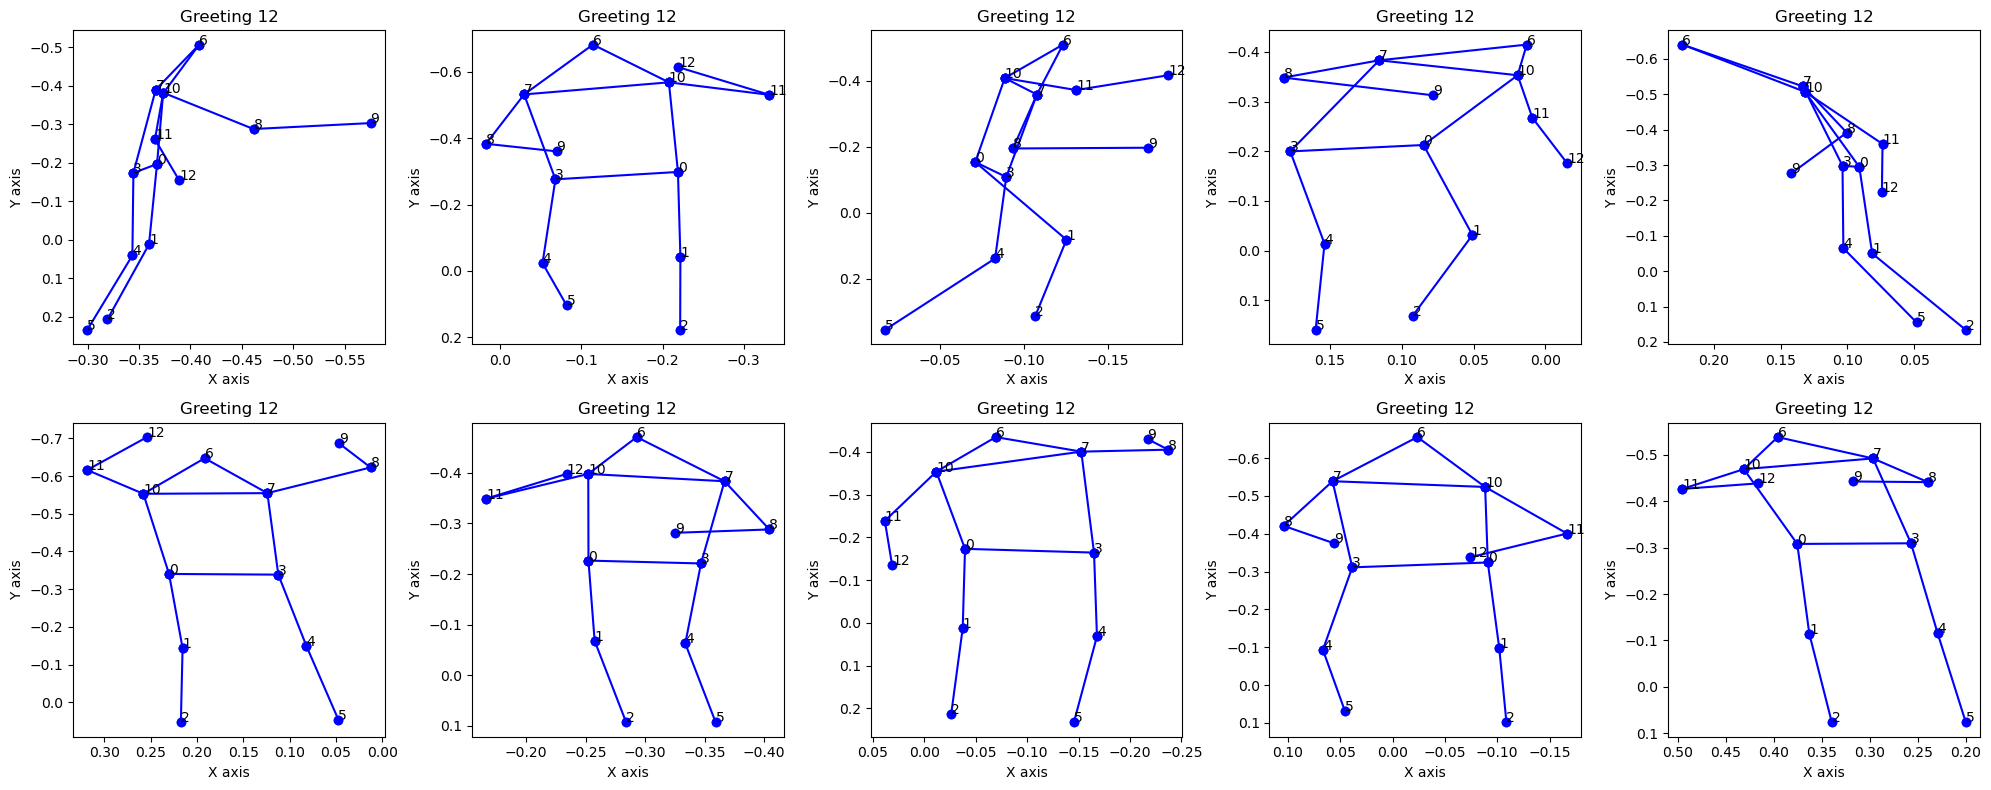

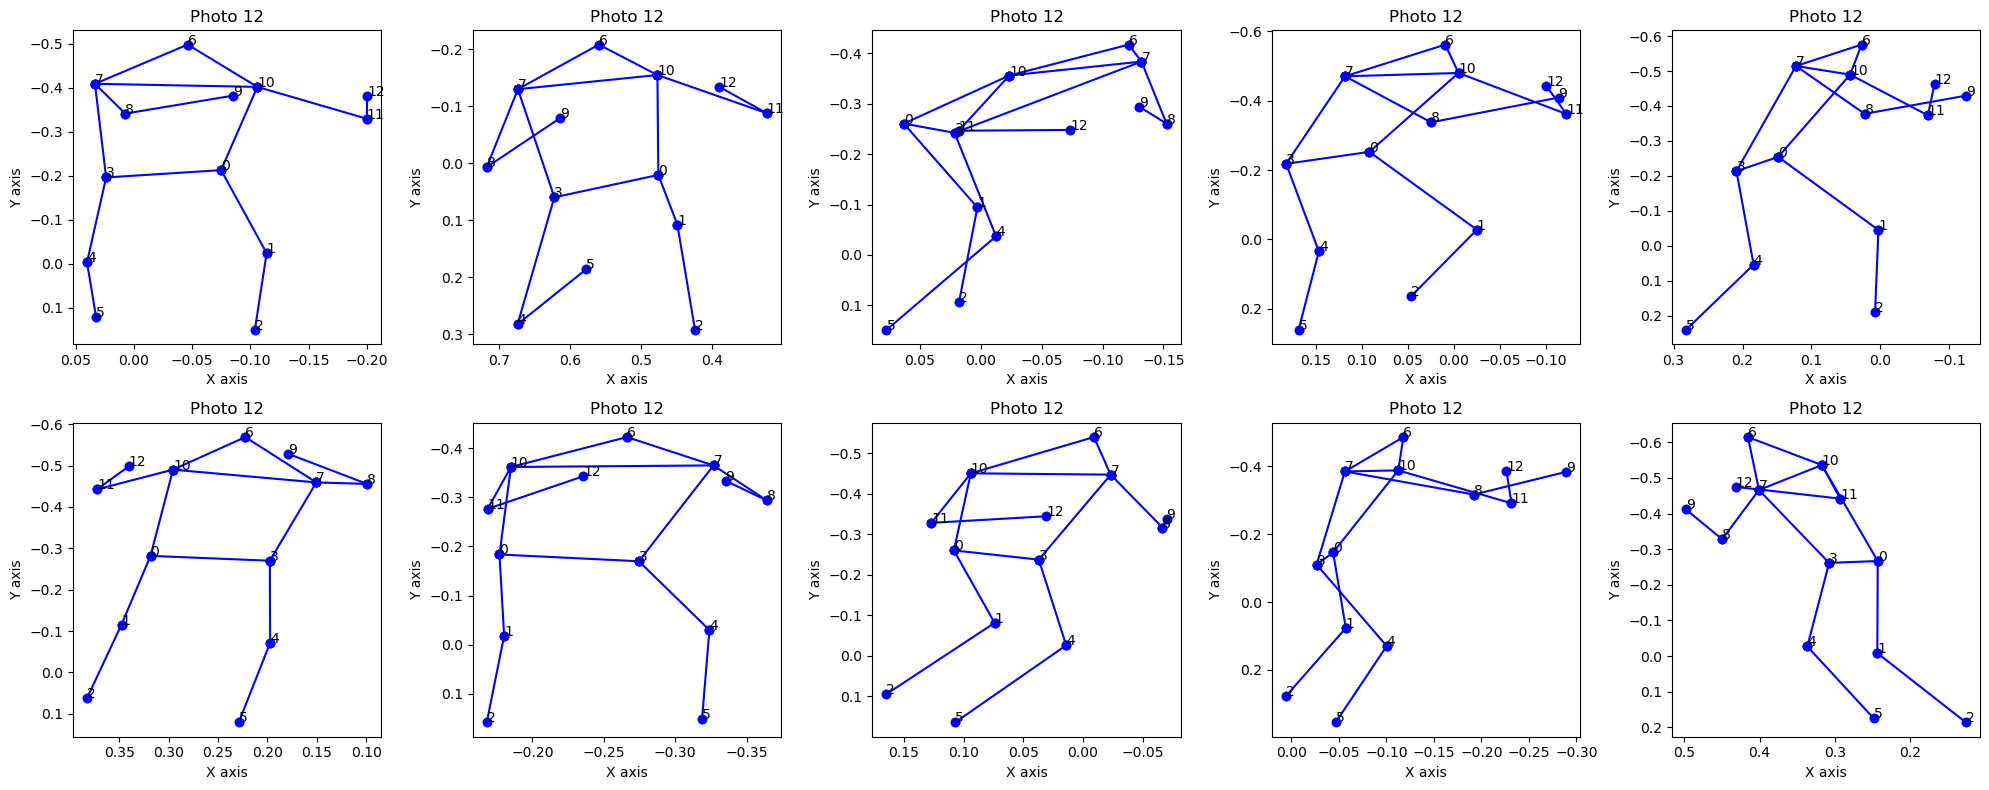

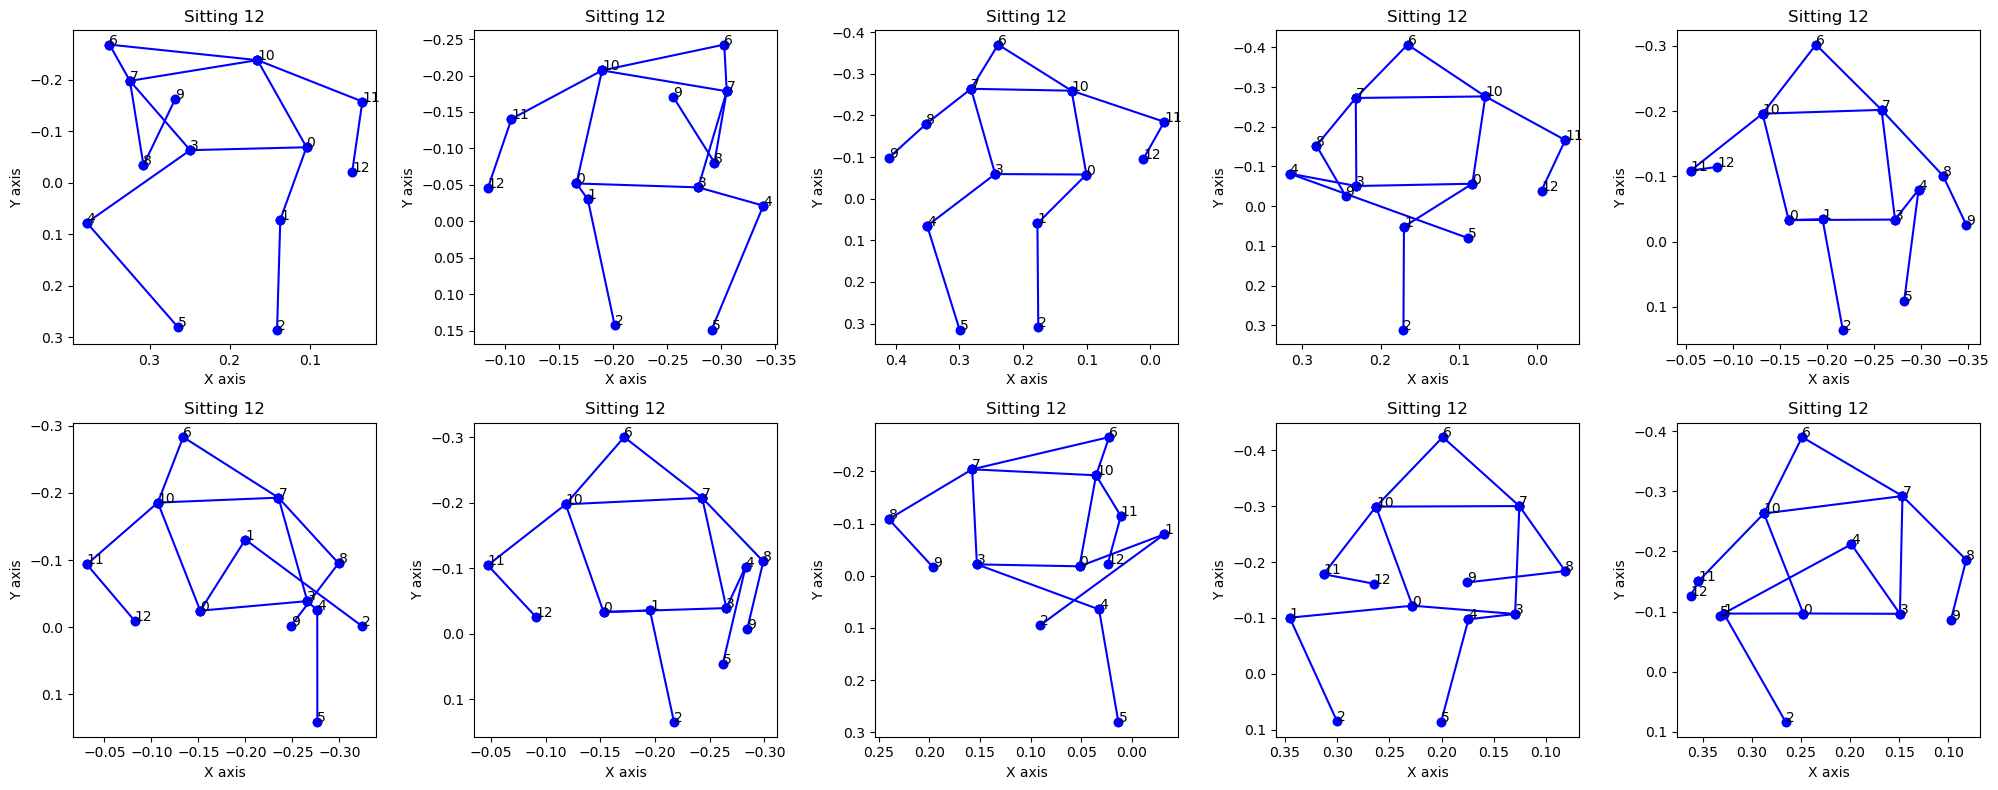

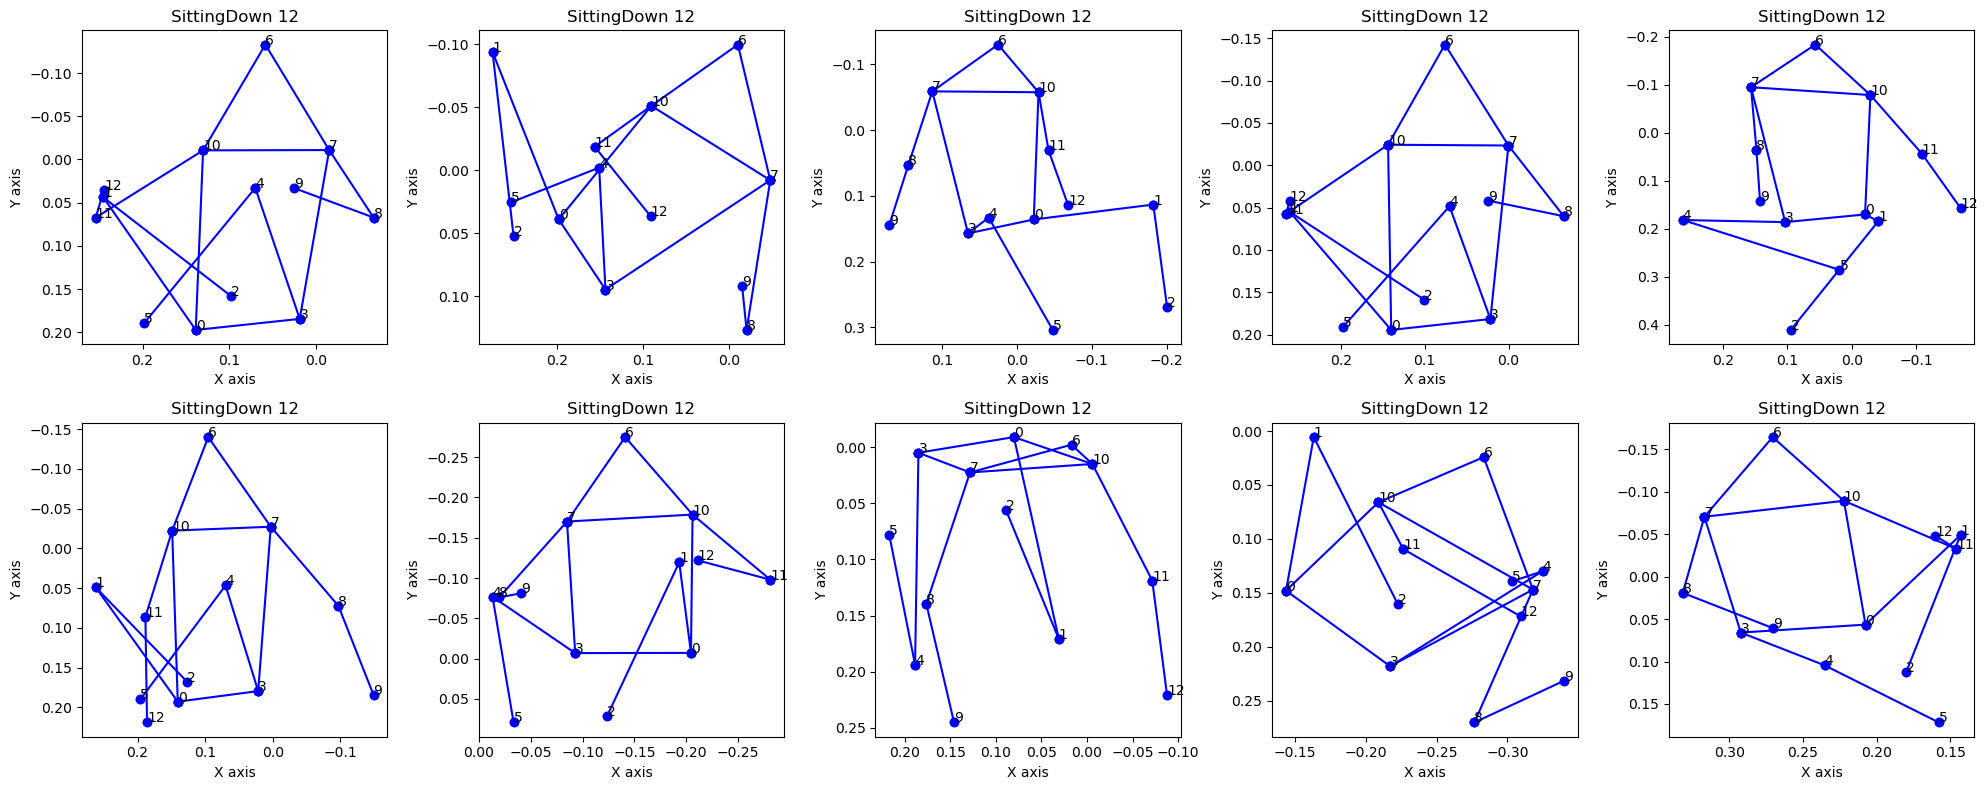

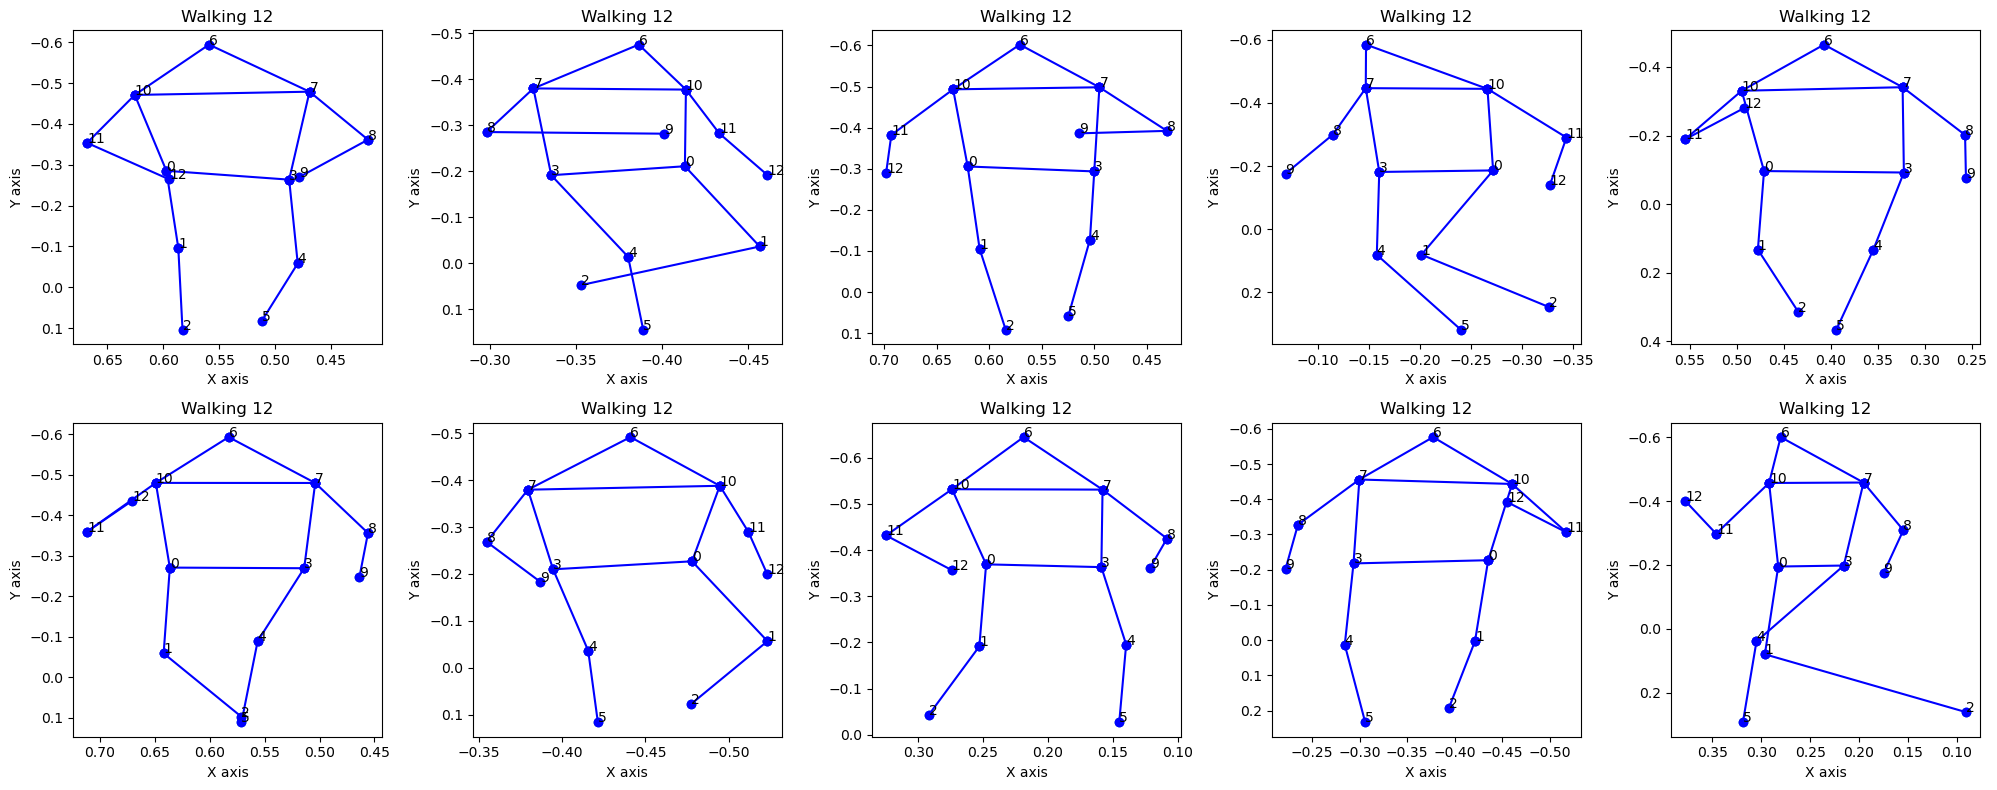

In [3]:
import matplotlib.pyplot as plt
from utils.graph_utils import HUMAN_POSE_EDGES, HUMAN_POSE_EDGES_CUSTOM

def visualize_2d_pose_actions(poses, action, k=10):
    plt.figure(figsize=(20, 8))

    for i in range(k):
        pose_idx = np.random.choice(len(poses))
        pose = poses[pose_idx]

        plt.subplot(2, k//2, i+1)
        plt.scatter(pose[:, 0], pose[:, 1])

        for i, xy in enumerate(pose):
            plt.annotate(f'{i}', xy=xy)

        for joints in HUMAN_POSE_EDGES:
            x1, y1 = pose[joints[0]]
            x2, y2 = pose[joints[1]]
            plt.plot([x1, x2], [y1, y2], 'bo-')

        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.title(f'{action} {i}')
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()


    plt.tight_layout()
    plt.show()

out_poses_3d, out_poses_2d, out_actions = create_train_test_files(subjects_test, dataset, keypoints, "test", processed_dataset_path,  keep_actions=keep_actions)
for action in np.unique(out_actions):
    out_poses_2d_action = out_poses_2d[out_actions == action]
    visualize_2d_pose_actions(out_poses_2d_action, action=action)